O primeiro passo é garantir que está com a última versão da biblioteca instalada.

In [46]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

Importamos a função ddg_images da biblioteca duckduckgo_search, que é usada para realizar uma pesquisa de imagens na internet usando o DuckDuckGo.
Importamos o pacote fastcore.all para usar o método itemgot cuja função vai ser extrair a URL de cada imagem de cada dicionário e retornar uma lista de URLs como resultado da função.

Definimos a função search_image que recebe como argumentos uma string (term que representa o termo de pesquisa para as imagens) e um inteiro (max_images que representa o número máximo de imagens retornadas pela pesquisa). A função retorna uma lista de URLs das imagens encontradas.

In [47]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Pesquisamos imagens de pássaros e retornamos o URL da imagem.

In [48]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

Importamos a função download_url do pacote fastdownload usada para baixar arquivos da internet e salvar localmente em um caminho especificado.

Definimos o nome do arquivo de destino para a imagem.
A função download_url é chamada com os argumentos urls[0] em que urls é uma lista é uma lista de URLs onde a primeira URL corresponde à imagem desejada, dest que é a imagem procurada, e show_progress é definido como False para não exibir a barra de progresso do download.

Importamos a biblioteca fastai.vision usada para simplificar o processo de treinamento de modelos de visão computacional.

A função Image.open(dest) é usada para abrir uma imagem, cujo caminho é passado como argumento da função (dest).
A função to_thumb é chamada na imagem aberta, passando '256' como argumento para os parâmetros de largura e altura, criando uma uma miniatura da imagem redimensionada com a altura e largura especificadas.

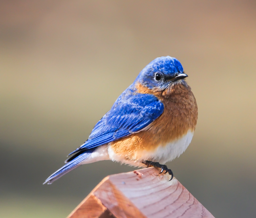

In [49]:
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256, 256)

Agora faremos o mesmo com imagens de florestas.

Searching for 'forest photos'


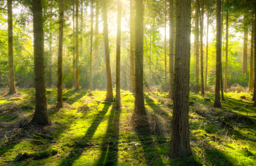

In [50]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

Nossas pesquisas parecem estar dando resultados razoáveis, então vamos pegar alguns exemplos de cada uma das imagens de pássaros e florestas e salvar cada grupo de fotos em uma pasta diferente (também estamos tentando pegar uma variedade de condições de iluminação):

In [51]:
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f' {o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f' {o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for ' forest sun photo'
Searching for ' forest shade photo'
Searching for 'bird photo'
Searching for ' bird sun photo'
Searching for ' bird shade photo'


Algumas imagens podem não ter sido baixadas corretamente, o que leva nosso modelo a falhar, então vamos removê-las.

In [52]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

Para treinar um modelo precisaremos de DataLoaders, que é um objeto que contém um conjunto de treinamento (as imagens usadas para criar um modelo) e um conjunto de validação (as imagens usadas para verificar a precisão de um modelo - não usadas durante o treinamento). No fastai, podemos criar isso e visualizar as imagens dele. 

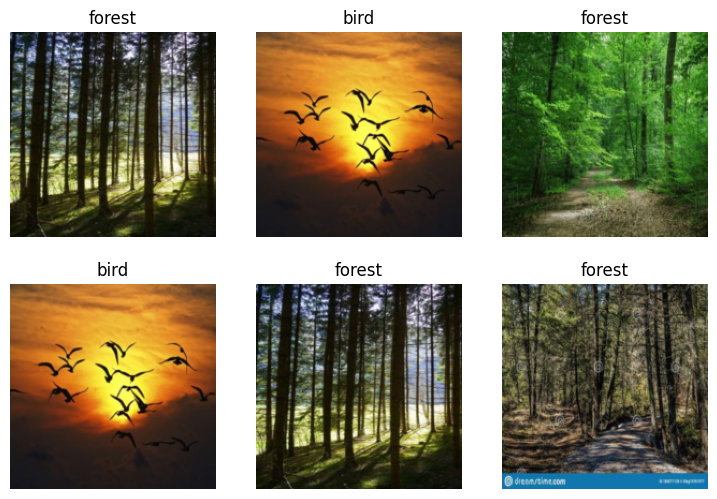

In [53]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
    ).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

As entradas do modelo são imagens, e as saídas são categorias (nesse caso pássaros ou florestas).

In [54]:
blocks=(ImageBlock, CategoryBlock),

Para localizar todas as entradas para nosso modelo, executamos a função get_image_files (que retorna uma lista de todos os arquivos de imagem em um caminho).

In [55]:
get_items = get_image_files,

Dividimos os dados em conjuntos de treinamentos e validação aleatoriamente, usando 20% dos dados para o conjunto de validação.

In [56]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)

Os rótulos (valores y) são o nome do pai de cada arquivo (o nome da pasta em que estão, que será pássaro ou floresta).

In [57]:
get_y = parent_label

Antes do treinamento, redimensionamos cada imagem para 192x192 pixels comprimindo (em vez de cortá-la).

In [58]:
item_tfms = [Resize(192, method='squish')]

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais usado e mais rápido é o resnet18.

A biblioteca fastai vem com um método útil fine_tune() que usa automaticamente as melhores práticas para ajustar um modelo pré-treinado, então vamos usá-lo.

In [59]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.424610,0.115135,0.030303,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.027187,0.000106,0.000000,01:14
1,0.016505,0.000047,0.000000,00:54
2,0.010922,0.000033,0.000000,00:54


Aqui vamos testar como o modelo classifica o pássaro que baixamos no início:

In [60]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a : {is_bird}.")
print(f"Probability it's a bird: {probs[0]: 4f}")

This is a : bird.
Probability it's a bird:  1.000000
